# EnergyDistance: 

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
#plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from dask.distributed import Client
import sklearn

In [3]:
# Please note that if we import the whole folder using __init__.py we would be running into ba Dask CanceledError due to different 
# imported Dask conflict, so we have to import only scEnergy script
import sys
sys.path.append("..")
import Templates.tools.scEnergy as eng 

In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
adata = sc.read_h5ad(ED_file)

NameError: name 'sc' is not defined

In [ ]:
adata

In [ ]:
#adata.obs_names_make_unique()

## Filter adata

In [7]:
#adata = adata[adata.obs["DemuxAssignment_hashing"]!="POSITIVE_CONTROL"].copy()

In [ ]:
#adata= adata[~adata.obs.index.duplicated(keep='first')].copy()

## correct gene_symbol for ENSGIDs

In [ ]:
adata.obs['gene_symbol'] = adata.obs['gene_symbol'].apply(lambda x:x.split('_')[0])

## Subsampling NTCs

In [8]:
NTC = adata[adata.obs["gene_symbol"]=="NTC"].copy()

In [9]:
if n is not None:
    NTC = NTC[NTC.obs.sample(n = n).index.copy()].copy()

In [10]:
NTC

AnnData object with n_obs × n_vars = 1000 × 32011
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Create only genes dataframe

In [11]:
genes = [el for el in adata.obs['gene_symbol'].unique()]

In [12]:
genes.remove("NTC")

In [13]:
GENE = adata[adata.obs["gene_symbol"].isin(genes)].copy()

In [14]:
GENE

AnnData object with n_obs × n_vars = 434266 × 32011
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Concatenate dataframes

In [15]:
c = NTC.concatenate(GENE)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [16]:
c

AnnData object with n_obs × n_vars = 435266 × 32011
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch'
    var: 'Symbol'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

## Create dictionary with NTCs. Pool them first

### This is to calculate consistency among NTCs

In [17]:
ntcs_perturbations = [el for el in NTC.obs['DemuxAssignment_crispr'].unique()]

### Separate NTCs

In [20]:
ntcs = {}

for el in ntcs_perturbations:
    v = eng.get_values_umap(c, 'DemuxAssignment_crispr', el)
    ntcs[el] = c[v].obsm[embeddings_key]

In [20]:
pert = {}

for el in genes:
    v = eng.get_values_umap(c, 'gene_symbol', el)
    pert[el] = c[v].obsm[embeddings_key]

In [21]:
ntcs_pool = {}
W = eng.get_values_umap(c, 'gene_symbol', "NTC")
ntcs_pool['pool'] = c[W].obsm[embeddings_key]

## Run energy distance on individual NTCs to find inconsitent NTCs

In [ ]:
ntc_consistency = eng.run(
    client = Client(processes=True, n_workers=32),
    perturbations = ntcs, 
    controls = ntcs_pool,
    pool = 'No'
)

In [ ]:
ntc_consistency = pd.DataFrame(ntc_consistency).T

In [ ]:
ntc_consistency

### Show only inconsistent NTCs with pVAL lower than the defined cut-off

In [ ]:
ntc_consistency[ntc_consistency['pvalue']<=pVAL]

In [ ]:
rm_ntcs = ntc_consistency[ntc_consistency['pvalue']<=0.01].index.tolist()
rm_ntcs

In [ ]:
c.obs['rm_ntc'] = 'No'
c.obs.loc[c.obs['DemuxAssignment_crispr'].isin(rm_ntcs), 'rm_ntc'] = 'Yes'

In [ ]:
c = c[c.obs['rm_ntc']=='No']
c

### Update NTCs

In [ ]:
ntcs_pool = {}
W = eng.get_values_umap(c, 'gene_symbol', "NTC")
ntcs_pool['pool'] = c[W].obsm[embeddings_key]

## Calculate actual EnergyDistance as ed

In [24]:
ed = eng.run(
    client = Client(processes=True, n_workers=32),
    perturbations = pert, 
    controls = ntcs_pool,
    pool = 'Yes'
)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39125 instead
  warnings.warn(


### Restart the client before new Computations with the refreshed client

In [ ]:
#client = Client()
#client.restart()

2023-06-06 14:36:21,726 - distributed.nanny - WARNING - Restarting worker
2023-06-06 14:36:21,874 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34174/status,
Dashboard: http://127.0.0.1:34174/status,Workers: 2
Total threads: 2,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46607,Workers: 2
Dashboard: http://127.0.0.1:34174/status,Total threads: 2
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:33703,Total threads: 1
Dashboard: http://127.0.0.1:39119/status,Memory: 60.00 GiB
Nanny: tcp://127.0.0.1:42641,


In [25]:
PVAL = pd.DataFrame(ed).T.sort_values(by='pvalue')
PVAL

,pvalue,statistic,control_key
SIN3A,0.0,8.375876,pool
ZNF233,0.0,8.935745,pool
RIPK4,0.0,16.204236,pool
RFT1,0.0,14.500461,pool
LGALS3BP,0.0,4.692784,pool
...,...,...,...
TINAGL1,0.999,1.163288,pool
USP12,0.999,1.063748,pool
TRGV5,1.0,0.91046,pool
GABRB1,1.0,1.105557,pool


#### p-value should be 1/1000 at minimum (for 1000 permutations)

In [ ]:
PVAL['pvalue'] = PVAL['pvalue'].replace(0,0.001)

In [ ]:
PVAL['gene_symbol'] = PVAL.index
PVAL.to_csv(out_csv)

### Add the energy distance info to adata

In [26]:
ed_df = pd.DataFrame(ed).T.copy()

In [27]:
ed_df['gene_symbol'] = ed_df.index
ed_df=ed_df.reset_index(drop=True)

In [ ]:
ed_df['pvalue'] = ed_df['pvalue'].replace(0,0.001)

In [28]:
ed_df = ed_df.rename(columns={"pvalue":"energy_distance_pvalue","statistic":"energy_distance_statistic","control_key":"energy_distance_control_key"})

In [29]:
df_uns = adata.obs.reset_index().merge(ed_df, on="gene_symbol", how="left").set_index('index')
df_uns.index.name = None

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [30]:
b=['energy_distance_pvalue','energy_distance_statistic']#,'energy_distance_control_key','phenotype']

for el in b:
    df_uns[el] = df_uns[el].astype(float)

In [31]:
df_uns.head()

,Sample,Barcode,demux_type,assignment,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,S_score,SCN_class,demux_type_crispr,assignment_crispr,gene_symbol,class,rm_ntc,energy_distance_pvalue,energy_distance_statistic,energy_distance_control_key
0,SAM24424070_Replicate1,AAACCCAAGCGATGCA-1,singlet,DLD1-infected-not-transfected,2240,4930.0,343.0,6.957404,1096.0,22.231237,...,-0.062182,Untreatedclus,singlet,ENSG00000176922_4,OR51S1,nonessential,No,0.862,3.401349,pool
1,SAM24424070_Replicate1,AAACCCAAGGATTTCC-1,singlet,DLD1-infected-not-transfected,1921,5025.0,425.0,8.457711,1450.0,28.855721,...,-0.362787,Untreatedclus,singlet,ENSG00000168394_3,TAP1,target,No,0.324,2.908847,pool
2,SAM24424070_Replicate1,AAACCCAAGTCATGAA-1,singlet,DLD1-infected-not-transfected,1435,3284.0,217.0,6.607796,1091.0,33.221680,...,-0.240475,Untreatedclus,singlet,NTC_736,NTC,ntc,No,1.000,0.000000,pool
3,SAM24424070_Replicate1,AAACCCACAAACCATC-1,singlet,DLD1-infected-not-transfected,1855,4590.0,211.0,4.596950,1275.0,27.777779,...,-0.141213,Untreatedclus,singlet,ENSG00000171298_1,GAA,target,No,0.424,1.680654,pool
4,SAM24424070_Replicate1,AAACCCACAATGGCAG-1,singlet,DLD1-infected-not-transfected,1669,3328.0,109.0,3.275240,759.0,22.806492,...,0.215034,Untreatedclus,singlet,NTC_502,NTC,ntc,No,1.000,0.000000,pool


In [32]:
#df_uns.index = df_uns.index.astype(str)

In [ ]:
df_uns = df_uns.drop(columns='energy_distance_control_key')

In [33]:
df_uns['phenotype'] = 'No'
df_uns.loc[df_uns['energy_distance_pvalue']<=pVAL, 'phenotype'] = 'Yes'

In [34]:
PHENO = df_uns[df_uns['phenotype']=='Yes'].copy()
PHENO['gene_symbol'].nunique()

113

## Update the annadata object and write out the output

In [ ]:
df_uns_ED = df_uns[['energy_distance_pvalue','energy_distance_statistic','phenotype']].copy()
df_uns_ED = df_uns_ED.rename(columns={'phenotype': 'phenotype_@0.05'})

In [ ]:
if 'energy_distance' not in adata.uns:
    adata.uns["energy_distance"]={}

In [ ]:
adata.uns["energy_distance"][key_uns]=df_uns_ED

In [35]:
adata.write(ED_file)

## Data Tabulation

In [36]:
df_uns.groupby(['SCN_class', 'phenotype'])['gene_symbol'].size()

SCN_class      phenotype
DOXclus        No            1263
               Yes             43
Untreatedclus  No           13743
               Yes            284
rand           No             507
               Yes             25
Name: gene_symbol, dtype: int64

In [37]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='DOXclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
10,IPO9,3
21,PNMA1,2
2,CD200R1L,2
5,EFNA1,2
6,FRMPD3,2
7,HID1,2
8,HTR3E,2
28,SMS,2
25,SELPLG,2
26,SHISA8,1


In [38]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='Untreatedclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
45,KCNH6,7
29,FAM90A1,7
19,COG5,7
75,PPP3R2,7
24,EFNA1,7
...,...,...
70,PDE12,1
7,ASH2L,1
76,RFT1,1
78,RTEL1-TNFRSF6B,1


In [39]:
df_uns[(df_uns['phenotype']=='Yes')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)[:30]

,gene_symbol,cnt
25,EFNA1,9
80,PPP3R2,8
31,FAM90A1,7
20,COG5,7
48,KCNH6,7
1,ABCC2,7
30,ERN1,7
69,OTUB2,6
37,GNG7,6
46,ISM2,6


## Data Visulaization

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='energy_distance_pvalue', ylabel='Count'>

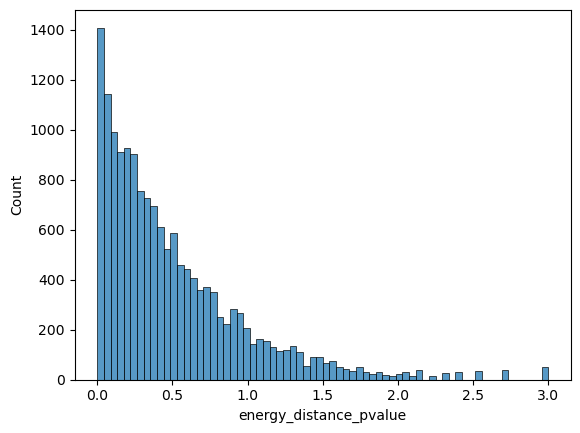

In [40]:
sns.histplot(-np.log10(df_uns['energy_distance_pvalue']))